## Обзор базовых моделей ML

### Цель

    Осмотреть базовые алгоритмы машинного обучения в задаче мультиклассовой классификации.
    Посмотреть на эффективность данных моделей.
    Сравнить методы векторизации BoW и TF-IDF.

### Данные

Набор данных представлен записями сделанными пользователями с Толоки.

    entry - запись о трате сделанная пользователем
    category - одна из базовых категорий, определены пользователями
    confidence - уверенность в ответе пользователей после агрегации по методу Дэвида-Скина
    
### Базовые категории

Housing:

    Rent or mortgage payments, property taxes, HOA dues, and home repair & maintenance costs.

Transportation:

    Car payments, registration and DMV fees, gas, maintenance, parking, tolls, and public transit.

Groceries & Dining:

    Groceries,  dining out, work lunches, food delivery, baby food, pet food etc.

Utilities & Phone:

    Water, electricity, gas and sewage bills. Cell phone, cable, and internet expenses. Streaming services and subscriptions.

Medical & Healthcare:

    Out-of-pocket costs for primary care, specialty care (dermatologists, psychologists, etc.), dental care, urgent care, prescriptions etc.

Recreation & Entertainment:

    Concert & sporting tickets, family activities & vacations, gifts.

Personal:

    Gym memberships, clothes and shoes, beauty treatments, hobbies.

Saving & Debt:

    Credit card bills, personal loans, or student loans. Investing and saving of all kind.

Miscellaneous:

    All that is clearly some expense but doesn't fit into main categories.

Entry is incomprehensible (категория `nonsense`):

    Please mark this option if an expense note is not understandable.

## EDA

Установим дополнительную библиотеку pandas_profiling для EDA и библиотеку LightGBM.

In [1]:
!pip install pandas_profiling -q

In [2]:
!pip install lightgbm -q

Загрузка необходимых модулей.

In [3]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords

#nltk.download("stopwords") # поддерживает удаление стоп-слов
#nltk.download('punkt') # делит текст на список предложений
#nltk.download('wordnet') # проводит лемматизацию

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import lightgbm as lgb

from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from keras import optimizers

Зададим глобальные переменные.

In [4]:
SEED = 31416

Загрузим датасет и осмотрим данные.

In [5]:
df = pd.read_csv('toloka_df.csv', index_col='Unnamed: 0')
df.drop(columns='confidence', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry     11550 non-null  object
 1   category  11550 non-null  object
dtypes: object(2)
memory usage: 270.7+ KB


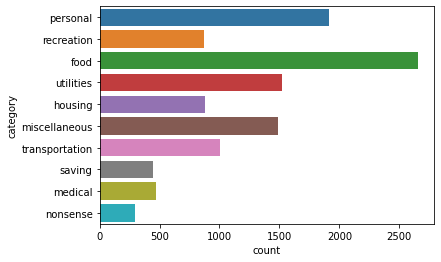

In [7]:
sns.countplot(data=df, y='category')
plt.show()

Отбросим данные с категорией `nonsense`, чтобы не засорять данные.

In [8]:
df = df[df['category'] != 'nonsense']
df = df[df['category'] != 'miscellaneous']

In [9]:
df.profile_report().to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Сбросим полные дубликаты чтобы убрать bias.

In [10]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7809 entries, 0 to 7808
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry     7809 non-null   object
 1   category  7809 non-null   object
dtypes: object(2)
memory usage: 122.1+ KB


## Предобработка текста

Очистим и лемматизируем наши тексты.

In [12]:
lemmatize = nltk.WordNetLemmatizer()

def cleaning(row):
    text = re.sub('[^a-zA-Z]', ' ', row.entry).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова
    row['entry_new'] = ' '.join(text) # соединяем слова
    return row

Создадим столбец с очищенными леммами.

In [13]:
df = df.apply(cleaning, axis=1)

Посмотрим на результат.

In [14]:
df.sample(5)

,entry,category,entry_new
3719,personal upkeep,personal,personal upkeep
6171,bus fare from work - 100,transportation,bus fare from work
5886,Library late return fee,recreation,library late return fee
2276,Visa runner's fee,saving,visa runner s fee
6812,adult male sox - 3.99,personal,adult male sox


Создадим объект векторизатора, обучим и применим к новому столбцу стратегию "мешок слов".

In [15]:
count_vectorizer = CountVectorizer(stop_words="english")
features_c = count_vectorizer.fit_transform(df.entry_new)

In [16]:
features_c

<7809x2725 sparse matrix of type '<class 'numpy.int64'>'
	with 16850 stored elements in Compressed Sparse Row format>

Создадим объект векторизатора, обучим и применим к новому столбцу стратегию "TF-IDF".

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
features_t = tfidf_vectorizer.fit_transform(df.entry_new)

In [18]:
features_t

<7809x2725 sparse matrix of type '<class 'numpy.float64'>'
	with 16850 stored elements in Compressed Sparse Row format>

Применим LabelEncoder чтобы закодировать наши цели (столбец `category`).

In [19]:
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.category)

In [20]:
target

array([3, 4, 0, ..., 6, 6, 7])

Разделим данные на обучающие и тестовые выборки.

In [21]:
X_c, X_c_test, y_c, y_c_test = train_test_split(features_c, target, random_state=SEED, stratify=target)
X_t, X_t_test, y_t, y_t_test = train_test_split(features_t, target, random_state=SEED, stratify=target)

Проверим разделение по классам.

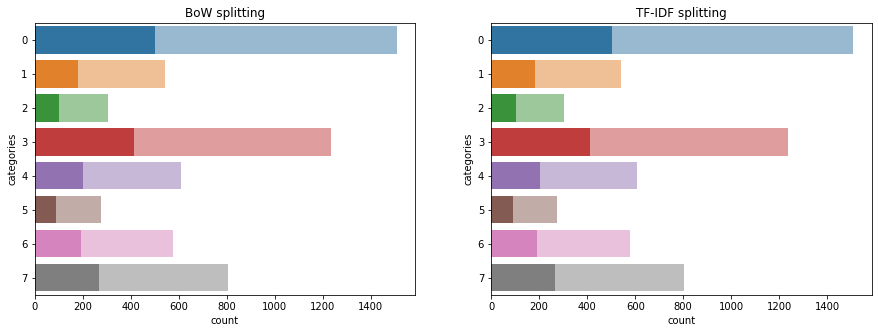

In [22]:
c_train = pd.DataFrame(y_c, columns=['categories'])
c_test = pd.DataFrame(y_c_test, columns=['categories'])
t_train = pd.DataFrame(y_t, columns=['categories'])
t_test = pd.DataFrame(y_t_test, columns=['categories'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=c_train, y='categories', alpha=.5, ax=ax1)
sns.countplot(data=c_test, y='categories', alpha=1, ax=ax1)
ax1.set_title('BoW splitting')
sns.countplot(data=t_train, y='categories', alpha=.5, ax=ax2)
sns.countplot(data=t_test, y='categories', alpha=1, ax=ax2)
ax2.set_title('TF-IDF splitting')
plt.show()

## Работа с моделями

### GaussianNB

Проверим наивный классификатор Байеса.

In [23]:
%%time
nb_c = GaussianNB().fit(X_c.toarray(), y_c)
nb_t = GaussianNB().fit(X_t.toarray(), y_t)

CPU times: total: 531 ms
Wall time: 534 ms


Посмотрим на отчёт по классификации.

In [24]:
nb_predictions_c = nb_c.predict(X_c_test.toarray())
nb_predictions_t = nb_t.predict(X_t_test.toarray())

In [25]:
cr = classification_report(
    y_c_test, nb_predictions_c,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results = {}
results['GaussianNB BoW'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.930,0.688,0.791,503.000
housing,0.486,0.470,0.478,181.000
medical,0.345,0.578,0.432,102.000
personal,0.854,0.468,0.605,412.000
recreation,0.489,0.424,0.454,203.000
saving,0.163,0.736,0.267,91.000
transportation,0.644,0.694,0.668,193.000
utilities,0.752,0.601,0.668,268.000
accuracy,0.579,0.579,0.579,0.579
macro avg,0.583,0.582,0.545,1953.000


In [26]:
cr = classification_report(
    y_t_test, nb_predictions_t,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['GaussianNB TF-IDF'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.910,0.686,0.782,503.00
housing,0.478,0.486,0.482,181.00
medical,0.358,0.569,0.439,102.00
personal,0.818,0.468,0.596,412.00
recreation,0.475,0.414,0.442,203.00
saving,0.164,0.703,0.266,91.00
transportation,0.662,0.720,0.690,193.00
utilities,0.757,0.604,0.672,268.00
accuracy,0.580,0.580,0.580,0.58
macro avg,0.578,0.581,0.546,1953.00


Также визуализируем матрицу ошибок.

In [27]:
cm_c = confusion_matrix(y_c_test, nb_predictions_c)
cm_t = confusion_matrix(y_t_test, nb_predictions_t)

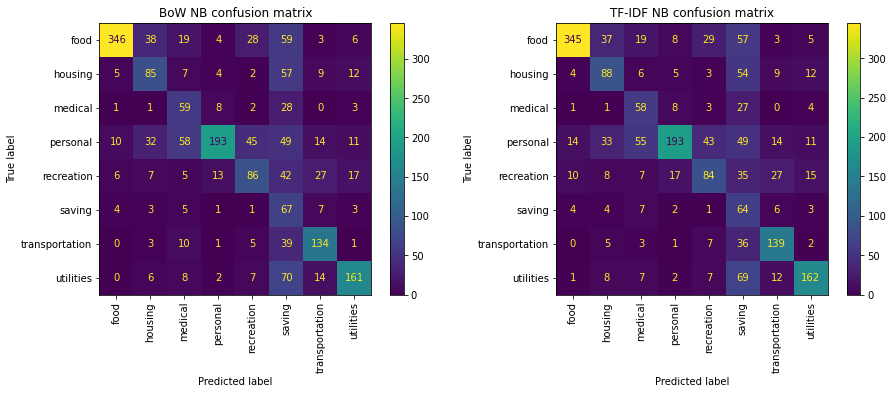

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd_c = ConfusionMatrixDisplay(cm_c, display_labels=le.classes_)
cmd_c.plot(ax=ax1)
ax1.set_xticklabels(labels=le.classes_, rotation=90)
ax1.set_title('BoW NB confusion matrix')
cmd_t = ConfusionMatrixDisplay(cm_t, display_labels=le.classes_)
cmd_t.plot(ax=ax2)
ax2.set_xticklabels(labels=le.classes_, rotation=90)
ax2.set_title('TF-IDF NB confusion matrix')
plt.show()

#### Выводы

Не лучшие результаты. Средневзвешенная метрика F1 = 0.515

Рассмотрим другие модели.

### LogisticRegression

Зададим и обучим классификаторы.

In [29]:
%%time
lr_c = LogisticRegression(random_state=SEED, n_jobs=-1).fit(X_c.toarray(), y_c)
lr_t = LogisticRegression(random_state=SEED, n_jobs=-1).fit(X_t.toarray(), y_t)

CPU times: total: 359 ms
Wall time: 26 s


Посмотрим на отчёт по классификации.

In [30]:
lr_predictions_c = lr_c.predict(X_c_test.toarray())
lr_predictions_t = lr_t.predict(X_t_test.toarray())

In [31]:
cr = classification_report(
    y_c_test, lr_predictions_c,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LogisticRegression BoW'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.763,0.936,0.841,503.0
housing,0.849,0.746,0.794,181.0
medical,0.889,0.549,0.679,102.0
personal,0.791,0.835,0.812,412.0
recreation,0.695,0.596,0.642,203.0
saving,0.770,0.516,0.618,91.0
transportation,0.955,0.876,0.914,193.0
utilities,0.824,0.821,0.822,268.0
accuracy,0.800,0.800,0.800,0.8
macro avg,0.817,0.734,0.765,1953.0


In [32]:
cr = classification_report(
    y_t_test, lr_predictions_t,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LogisticRegression TF-IDF'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.748,0.938,0.832,503.000
housing,0.858,0.735,0.792,181.000
medical,0.914,0.520,0.662,102.000
personal,0.768,0.842,0.803,412.000
recreation,0.701,0.576,0.632,203.000
saving,0.815,0.484,0.607,91.000
transportation,0.959,0.855,0.904,193.000
utilities,0.826,0.813,0.820,268.000
accuracy,0.793,0.793,0.793,0.793
macro avg,0.824,0.720,0.757,1953.000


Также визуализируем матрицу ошибок.

In [33]:
cm_c = confusion_matrix(y_c_test, lr_predictions_c)
cm_t = confusion_matrix(y_t_test, lr_predictions_t)

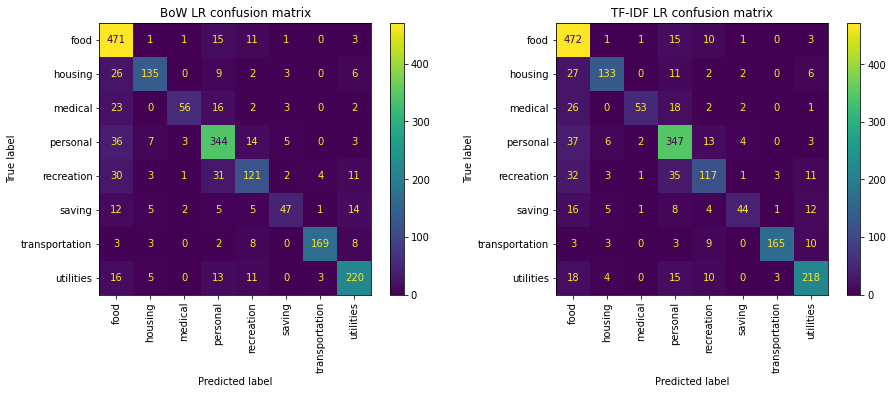

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd_c = ConfusionMatrixDisplay(cm_c, display_labels=le.classes_)
cmd_c.plot(ax=ax1)
ax1.set_xticklabels(labels=le.classes_, rotation=90)
ax1.set_title('BoW LR confusion matrix')
cmd_t = ConfusionMatrixDisplay(cm_t, display_labels=le.classes_)
cmd_t.plot(ax=ax2)
ax2.set_xticklabels(labels=le.classes_, rotation=90)
ax2.set_title('TF-IDF LR confusion matrix')
plt.show()

#### Выводы

Неплохие результаты. Средневзвешенная метрика F1 значительно лучше чем в наивном Байесе.

Рассмотрим модель LinearSVM.

### LinearSVM

Зададим и обучим классификаторы.

In [35]:
%%time
lsvm_c = LinearSVC(dual=False).fit(X_c.toarray(), y_c)
lsvm_t = LinearSVC(dual=False).fit(X_t.toarray(), y_t)

CPU times: total: 359 ms
Wall time: 367 ms


Посмотрим на отчёт по классификации.

In [36]:
lsvm_predictions_c = lsvm_c.predict(X_c_test.toarray())
lsvm_predictions_t = lsvm_t.predict(X_t_test.toarray())

In [37]:
cr = classification_report(
    y_c_test, lsvm_predictions_c,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LinearSVM BoW'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.807,0.930,0.864,503.000
housing,0.824,0.773,0.798,181.000
medical,0.788,0.618,0.692,102.000
personal,0.818,0.808,0.813,412.000
recreation,0.708,0.645,0.675,203.000
saving,0.754,0.538,0.628,91.000
transportation,0.936,0.907,0.921,193.000
utilities,0.814,0.847,0.830,268.000
accuracy,0.812,0.812,0.812,0.812
macro avg,0.806,0.758,0.778,1953.000


In [38]:
cr = classification_report(
    y_t_test, lsvm_predictions_t,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LinearSVM TF-IDF'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.807,0.928,0.863,503.000
housing,0.827,0.790,0.808,181.000
medical,0.795,0.608,0.689,102.000
personal,0.829,0.811,0.820,412.000
recreation,0.709,0.660,0.684,203.000
saving,0.754,0.538,0.628,91.000
transportation,0.937,0.922,0.930,193.000
utilities,0.830,0.854,0.842,268.000
accuracy,0.817,0.817,0.817,0.817
macro avg,0.811,0.764,0.783,1953.000


Также визуализируем матрицу ошибок.

In [39]:
cm_c = confusion_matrix(y_c_test, lsvm_predictions_c)
cm_t = confusion_matrix(y_t_test, lsvm_predictions_t)

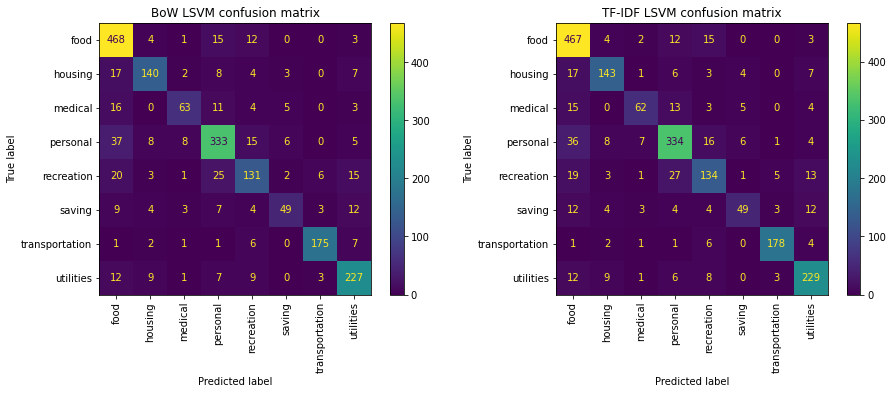

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd_c = ConfusionMatrixDisplay(cm_c, display_labels=le.classes_)
cmd_c.plot(ax=ax1)
ax1.set_xticklabels(labels=le.classes_, rotation=90)
ax1.set_title('BoW LSVM confusion matrix')
cmd_t = ConfusionMatrixDisplay(cm_t, display_labels=le.classes_)
cmd_t.plot(ax=ax2)
ax2.set_xticklabels(labels=le.classes_, rotation=90)
ax2.set_title('TF-IDF LSVM confusion matrix')
plt.show()

#### Выводы

Результаты чуть лучше чем у линейной регрессии.

Рассмотрим метод градиентного бустинга.

### LightGBM

Воспользуемся библиотекой градиентного бустинга от Microsoft.

In [41]:
%%time
lgbm_c = lgb.LGBMClassifier(
    objective='multiclassova', num_class=9, random_state=SEED, verbose=-1, is_unbalance=True
).fit(
    X_c.toarray(), y_c, eval_set=[(X_c_test.toarray(), y_c_test),], early_stopping_rounds=3, verbose=-1
)
lgbm_t = lgb.LGBMClassifier(
    objective='multiclassova', num_class=9, random_state=SEED, verbose=-1, is_unbalance=True
).fit(
    X_t.toarray(), y_t, eval_set=[(X_t_test.toarray(), y_t_test),], early_stopping_rounds=3, verbose=-1
)

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log

CPU times: total: 8.31 s
Wall time: 1.25 s


Посмотрим на отчёт по классификации.

In [42]:
lgbm_predictions_c = lgbm_c.predict(X_c_test.toarray())
lgbm_predictions_t = lgbm_t.predict(X_t_test.toarray())

In [43]:
cr = classification_report(
    y_c_test, lgbm_predictions_c,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LightGBM BoW'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.905,0.495,0.640,503.000
housing,0.687,0.508,0.584,181.000
medical,0.600,0.353,0.444,102.000
personal,0.399,0.852,0.544,412.000
recreation,0.672,0.394,0.497,203.000
saving,0.385,0.462,0.420,91.000
transportation,0.875,0.762,0.814,193.000
utilities,0.876,0.683,0.767,268.000
accuracy,0.604,0.604,0.604,0.604
macro avg,0.675,0.564,0.589,1953.000


In [44]:
cr = classification_report(
    y_t_test, lgbm_predictions_t,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['LightGBM TF_IDF'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.900,0.499,0.642,503.000
housing,0.676,0.541,0.601,181.000
medical,0.516,0.324,0.398,102.000
personal,0.397,0.845,0.540,412.000
recreation,0.659,0.399,0.497,203.000
saving,0.494,0.462,0.477,91.000
transportation,0.924,0.756,0.832,193.000
utilities,0.829,0.687,0.751,268.000
accuracy,0.606,0.606,0.606,0.606
macro avg,0.674,0.564,0.592,1953.000


Также визуализируем матрицу ошибок.

In [45]:
cm_c = confusion_matrix(y_c_test, lgbm_predictions_c)
cm_t = confusion_matrix(y_t_test, lgbm_predictions_t)

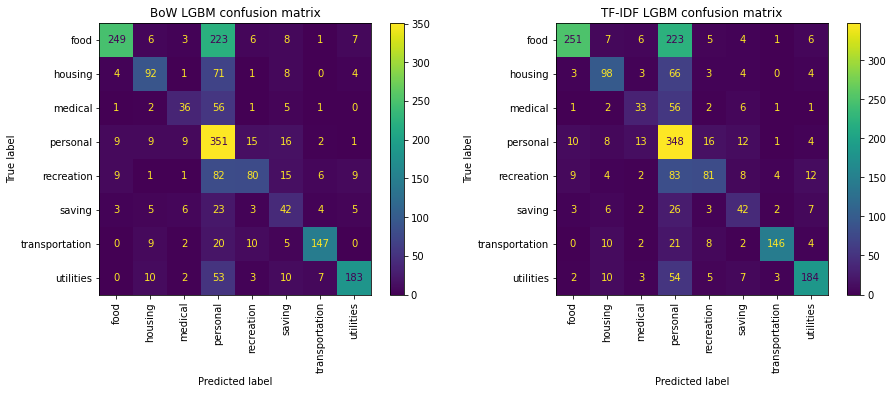

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd_c = ConfusionMatrixDisplay(cm_c, display_labels=le.classes_)
cmd_c.plot(ax=ax1)
ax1.set_xticklabels(labels=le.classes_, rotation=90)
ax1.set_title('BoW LGBM confusion matrix')
cmd_t = ConfusionMatrixDisplay(cm_t, display_labels=le.classes_)
cmd_t.plot(ax=ax2)
ax2.set_xticklabels(labels=le.classes_, rotation=90)
ax2.set_title('TF-IDF LGBM confusion matrix')
plt.show()

#### Выводы

Из литературы известно что модели градиентного бустинга показывают лучшие результаты среди классического ML при работе с табличными данными, с текстом же эти модели работают не лучшим образом, что и подтвердилось. Результаты лишь немногим лучше модели наивного Байеса.

### Нейронная сеть

Рассмотрим алгоритм работы простой нейронной сети, в которой будет 2 полносвязных слоя и 1 выходной с выходами по количеству классов.

Создадим последовательные модели.

In [47]:
nn_c = models.Sequential()
nn_t = models.Sequential()

Определим слои.

In [48]:
nn_c.add(layers.Dense(64, activation='relu', input_shape=(features_c.shape[1],)))
nn_c.add(layers.Dense(64, activation='relu'))
nn_c.add(layers.Dense(8, activation='softmax'))

nn_t.add(layers.Dense(64, activation='relu', input_shape=(features_t.shape[1],)))
nn_t.add(layers.Dense(64, activation='relu'))
nn_t.add(layers.Dense(8, activation='softmax'))

Определим компиляторы.

In [49]:
nn_c.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

nn_t.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Проведём обучение и запишем логи.

In [50]:
%%time

epochs = 20

history_c = nn_c.fit(
    X_c.toarray(), y_c,
    epochs=epochs, batch_size=128,
    validation_data=(X_c_test.toarray(), y_c_test),
    verbose=0
)

history_t = nn_t.fit(
    X_t.toarray(), y_t,
    epochs=epochs, batch_size=128,
    validation_data=(X_t_test.toarray(), y_t_test),
    verbose=0
)

history_dict_c = history_c.history
history_dict_t = history_t.history

CPU times: total: 28.7 s
Wall time: 7.87 s


Построим графики точности на этапах обучения и проверки.

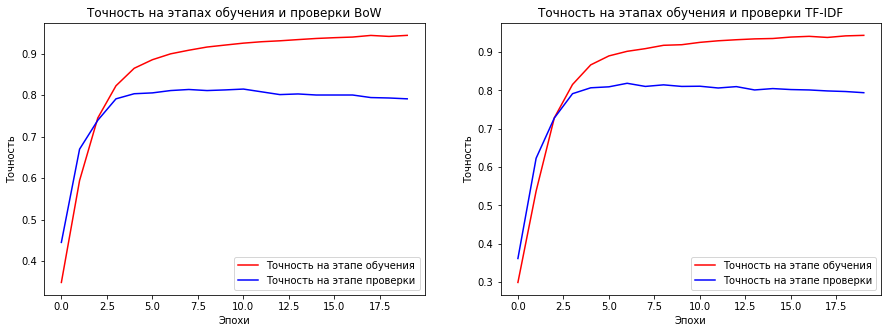

In [51]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(0, len(history_dict_c['accuracy']))
acc_values = history_dict_c['accuracy']
val_acc_values = history_dict_c['val_accuracy']
ax1.plot(epochs, acc_values, 'r', label = 'Точность на этапе обучения')
ax1.plot(epochs, val_acc_values, 'b', label = 'Точность на этапе проверки')
ax1.set_title('Точность на этапах обучения и проверки BoW')
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Точность')
ax1.legend()

epochs = range(0, len(history_dict_t['accuracy']))
acc_values = history_dict_t['accuracy']
val_acc_values = history_dict_t['val_accuracy']
ax2.plot(epochs, acc_values, 'r', label = 'Точность на этапе обучения')
ax2.plot(epochs, val_acc_values, 'b', label = 'Точность на этапе проверки')
ax2.set_title('Точность на этапах обучения и проверки TF-IDF')
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Точность')
ax2.legend()

plt.show()

Посмотрим на отчёт по классификации.

In [52]:
nn_predictions_c = [y.argmax() for y in nn_c.predict(X_c_test.toarray())]
nn_predictions_t = [y.argmax() for y in nn_t.predict(X_t_test.toarray())]

In [53]:
cr = classification_report(
    y_c_test, nn_predictions_c,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['NN BoW'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.878,0.871,0.874,503.000
housing,0.817,0.762,0.789,181.000
medical,0.772,0.598,0.674,102.000
personal,0.828,0.784,0.805,412.000
recreation,0.649,0.655,0.652,203.000
saving,0.366,0.615,0.459,91.000
transportation,0.930,0.902,0.916,193.000
utilities,0.819,0.828,0.824,268.000
accuracy,0.791,0.791,0.791,0.791
macro avg,0.757,0.752,0.749,1953.000


In [54]:
cr = classification_report(
    y_t_test, nn_predictions_t,
    target_names=le.classes_,
    output_dict=True, zero_division=0
)

results['NN TF-IDF'] = cr['weighted avg']

pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
food,0.868,0.879,0.874,503.000
housing,0.797,0.779,0.788,181.000
medical,0.677,0.618,0.646,102.000
personal,0.832,0.791,0.811,412.000
recreation,0.683,0.616,0.648,203.000
saving,0.393,0.626,0.483,91.000
transportation,0.916,0.907,0.911,193.000
utilities,0.840,0.825,0.832,268.000
accuracy,0.794,0.794,0.794,0.794
macro avg,0.751,0.755,0.749,1953.000


Также визуализируем матрицу ошибок.

In [55]:
cm_c = confusion_matrix(y_c_test, nn_predictions_c)
cm_t = confusion_matrix(y_t_test, nn_predictions_t)

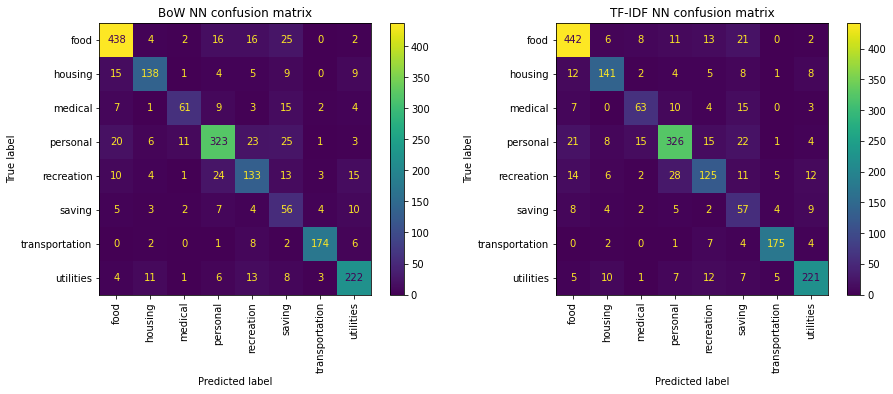

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd_c = ConfusionMatrixDisplay(cm_c, display_labels=le.classes_)
cmd_c.plot(ax=ax1)
ax1.set_xticklabels(labels=le.classes_, rotation=90)
ax1.set_title('BoW NN confusion matrix')
cmd_t = ConfusionMatrixDisplay(cm_t, display_labels=le.classes_)
cmd_t.plot(ax=ax2)
ax2.set_xticklabels(labels=le.classes_, rotation=90)
ax2.set_title('TF-IDF NN confusion matrix')
plt.show()

#### Выводы

Простая нейронная сеть с двумя полносвязными слоями выдаёт результаты схожие по оценкам с линейной регрессией.

## Заключение

В данной работе мы изучили базовые модели машинного обучения в задаче мультиклассовой классификации.

Данные были предобработаны с отбрасыванием категории `nonsense`, а также категории `miscellaneous`, т.к. иначе она засоряет  словарь и мешает определению других категорий. Значения метрики F1 до отбрасывания категории `miscellaneous` были на ~5% ниже. Следует задаться определённым порогом уверенности в ответе и при НЕ достижении его в ответе модели относить данный запрос в `miscellaneous`.

Общий объём словаря с полученных на Толоке строк составил.

In [57]:
len(count_vectorizer.vocabulary_)

2725

Также мы исследовали влияние векторизации на ответы моделей.

Было использовано два метода векторизации: Bag of Words и TF-IDF. Как видно из итоговой таблицы принципиальной разницы нет, вероятно, в связи с очень короткими ответами (1-3 слова).

In [58]:
pd.DataFrame(results).round(decimals=3).transpose()

,precision,recall,f1-score,support
GaussianNB BoW,0.708,0.579,0.615,1953.0
GaussianNB TF-IDF,0.696,0.580,0.614,1953.0
LogisticRegression BoW,0.804,0.800,0.796,1953.0
LogisticRegression TF-IDF,0.801,0.793,0.788,1953.0
LinearSVM BoW,0.811,0.812,0.809,1953.0
LinearSVM TF-IDF,0.816,0.817,0.814,1953.0
LightGBM BoW,0.707,0.604,0.614,1953.0
LightGBM TF_IDF,0.702,0.606,0.615,1953.0
NN BoW,0.806,0.791,0.796,1953.0
NN TF-IDF,0.803,0.794,0.797,1953.0


Логистическая регрессия, метод опорных векторов и простая нейронная сети дали схожие результаты. Чуть впереди по оценкам модель LinearSVM. Градиентный бустинг показал плохие результаты, как и ожидалось для не табличных данных.